In [ ]:
!pip install datasets
!pip install evaluate
!pip install accelerate -U
!pip install ttach
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

In [2]:
import requests
import torch
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_name = "google/vit-base-patch16-224"                        # the model name
image_processor = ViTImageProcessor.from_pretrained(model_name)   # load the image processor
model = ViTForImageClassification.from_pretrained(model_name)     # loading the pre-trained model

**Load Dataset**

In [ ]:
from datasets import load_dataset
ds = load_dataset("albertvillanova/medmnist-v2", "retinamnist")    # download & load the dataset

**Data Preprocessing**

In [5]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")

  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]

  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

In [6]:
labels = ds["train"].features["label"].names

def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [ ]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [ ]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={i: c for i, c in enumerate(labels)},
    label2id={c: i for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

In [10]:
# defining the training arguments
training_args = TrainingArguments(
  output_dir="./vit-base-retina", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=10,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=34,                # number of update steps before saving checkpoint
  eval_steps=34,                # number of update steps before evaluating
  logging_steps=34,             # number of update steps before logging
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)


In [11]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [12]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
34,1.258300,1.064814,0.533333,0.357761
68,1.087000,1.163537,0.558333,0.390053
102,0.957300,1.103499,0.500000,0.334062
136,0.754800,1.129705,0.500000,0.412891
170,0.525600,1.248934,0.508333,0.415048
204,0.332800,1.318578,0.525000,0.444898
238,0.169100,1.494629,0.500000,0.362988
272,0.082100,1.555782,0.516667,0.395728
306,0.039200,1.612952,0.500000,0.378947
340,0.022300,1.631139,0.533333,0.419044


TrainOutput(global_step=340, training_loss=0.5228470165939892, metrics={'train_runtime': 425.9751, 'train_samples_per_second': 25.354, 'train_steps_per_second': 0.798, 'total_flos': 8.369359908102144e+17, 'train_loss': 0.5228470165939892, 'epoch': 10.0})

**GradCAM Analysis on Test Data**

In [14]:
model.config.id2label.items()

dict_items([(0, '0'), (1, '1'), (2, '2'), (3, '3'), (4, '4')])

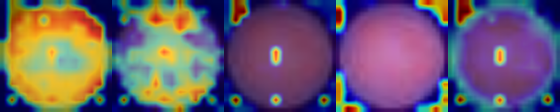

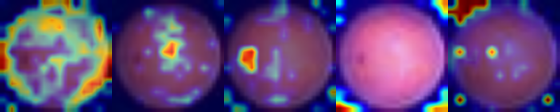

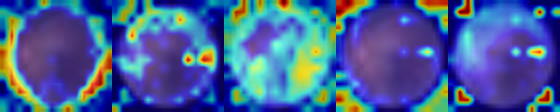

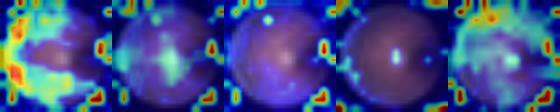

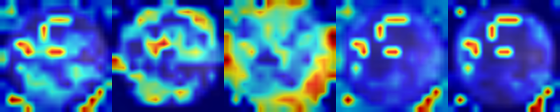

In [18]:
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
from transformers import ViTForImageClassification
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Model wrapper to return a tensor
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

# Translate the category name to the category index
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

# Helper function to run GradCAM on an image and create a visualization
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)

# Define the reshape transform for ViT model
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   14, 14, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

# Define the target layer for GradCAM
target_layer_gradcam = model.vit.encoder.layer[-2].output

# Define the targets for GradCAM
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, '0')),
                       ClassifierOutputTarget(category_name_to_index(model, '1')),
                       ClassifierOutputTarget(category_name_to_index(model, '2')),
                       ClassifierOutputTarget(category_name_to_index(model, '3')),
                       ClassifierOutputTarget(category_name_to_index(model, '4')),
                      ]

def process_images_with_grad_cam(images: List[str]):
    results = []
    for image_path in images:
        # Load the input image
        image = Image.open(image_path).convert("RGB")

        # Resize the input image to match the model's expected input size (224x224)
        image_resized = image.resize((224, 224))

        # Convert the resized image into a tensor
        tensor_resized = transforms.ToTensor()(image_resized)

        # Run Grad-CAM on the resized image
        visualization = run_grad_cam_on_image(model=model,
                                              target_layer=target_layer_gradcam,
                                              targets_for_gradcam=targets_for_gradcam,
                                              input_tensor=tensor_resized,
                                              input_image=image_resized,
                                              reshape_transform=reshape_transform_vit_huggingface)

        results.append(visualization)
    return results


image_paths = ["retina0.png", "retina1.png", "retina2.png", "retina3.png", "retina4.png"]
visualizations = process_images_with_grad_cam(images=image_paths)

# Display the visualizations
for visualization in visualizations:
    display(Image.fromarray(visualization))